In [1]:
print("Hello World")

Hello World


In [3]:
import torch
import numpy as np

In [4]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
#num of subprocesses to use for data loading
num_workers = 0
batch_size = 20
#validation percentage
valid_size = 0.2

In [6]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root = 'MNIST_data', 
                            train=True, 
                            download=False, 
                            transform=transform)
test_data = datasets.MNIST(root = 'MNIST_data', 
                            train=False, 
                            download=False, 
                            transform=transform)

In [7]:
#get indices for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [8]:
#define samplers for obtaining batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, 
                                           num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = valid_sampler, 
                                           num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                           num_workers = num_workers)

<h2><b>Visualise data</b></h2>

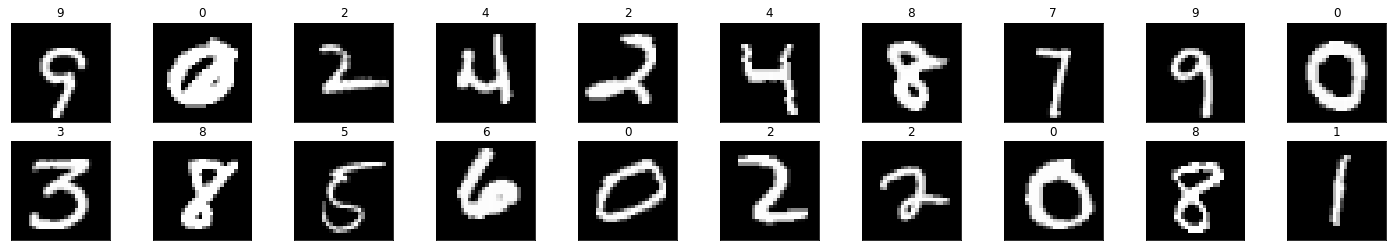

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

#obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

<h2><b>View image in more detail</b></h2>

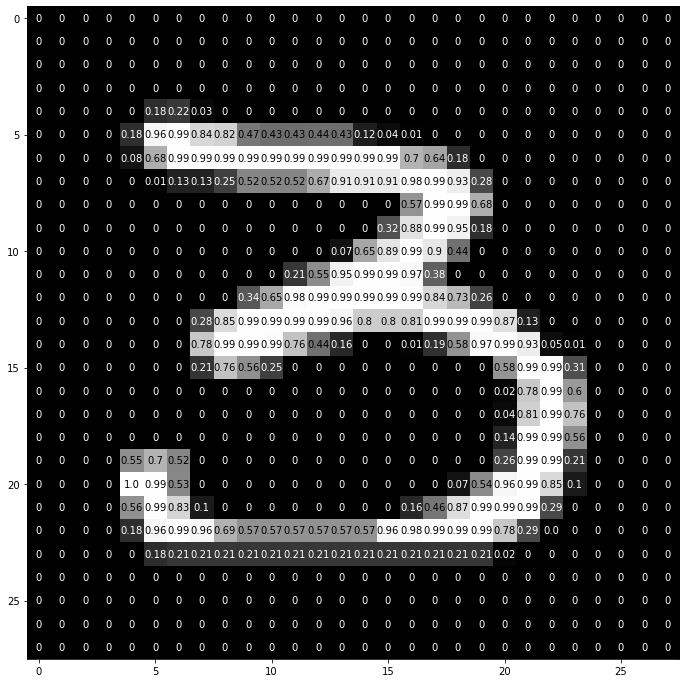

In [17]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y,x),
                   horizontalalignment = 'center',
                   verticalalignment = 'center',
                   color = 'white' if img[x][y]<thresh else 'black')

<h2><b>Define Architecture</b></h2>

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        drop = 0.2
        
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
        #flatten image
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

model = Net()
print(model)
        

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


<h2><b>Specify Loss and Optimization Functions</b></h2>

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

<h2><b>Train Network</b></h2>


Steps:
<ul>
<li>Clear grads</li>
<li>Forward prop</li>
<li>Loss calc</li>
<li>Back prop</li>
<li>Optimization step</li>
<li>Update average training loss</li>
</ul>

In [20]:
epochs = 50
#init min validation loss
valid_loss_min = np.Inf
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss+=loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
    ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.945818 	Validation Loss: 0.402937
Validation loss decreased (inf --> 0.402937).  Saving model ...
Epoch: 2 	Training Loss: 0.351751 	Validation Loss: 0.304851
Validation loss decreased (0.402937 --> 0.304851).  Saving model ...
Epoch: 3 	Training Loss: 0.280522 	Validation Loss: 0.255514
Validation loss decreased (0.304851 --> 0.255514).  Saving model ...
Epoch: 4 	Training Loss: 0.232400 	Validation Loss: 0.218489
Validation loss decreased (0.255514 --> 0.218489).  Saving model ...
Epoch: 5 	Training Loss: 0.200390 	Validation Loss: 0.192429
Validation loss decreased (0.218489 --> 0.192429).  Saving model ...
Epoch: 6 	Training Loss: 0.175587 	Validation Loss: 0.171327
Validation loss decreased (0.192429 --> 0.171327).  Saving model ...
Epoch: 7 	Training Loss: 0.154875 	Validation Loss: 0.154740
Validation loss decreased (0.171327 --> 0.154740).  Saving model ...
Epoch: 8 	Training Loss: 0.139544 	Validation Loss: 0.141336
Validation loss decreased (0.15474

In [14]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

<h2><b>Test the Trained Network</b></h2>

In [15]:
test_loss = 0.0
class_correct = list(0. for i in range (10))
class_total = list(0. for i in range (10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    #compare pred to label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i),
            100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i]))
             )
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. *np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total))
     )

Test Loss: 0.0628623

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 97% (1004/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 97% (869/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 98% (9816/10000)


<h2><b>Visualize Sample test Results</b></h2>

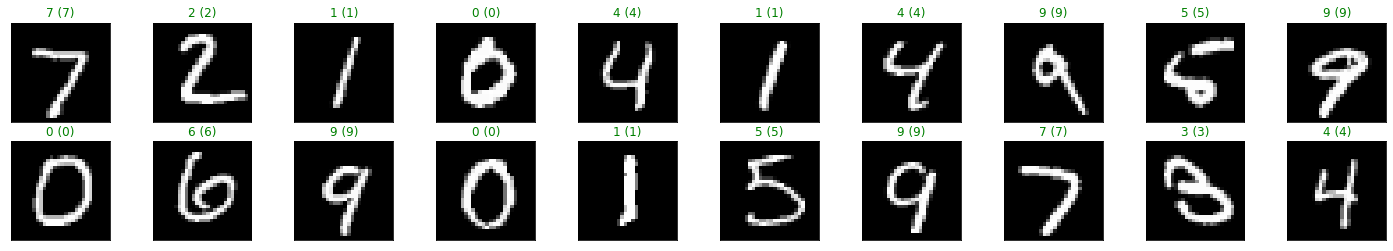

In [27]:
dataiter = iter(test_loader)
images , labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(
        str(preds[idx].item()),
        str(labels[idx].item())), color = ("green" if preds[idx] == labels[idx] else "red"))